#### DSB-SC Amplitude Modulation 

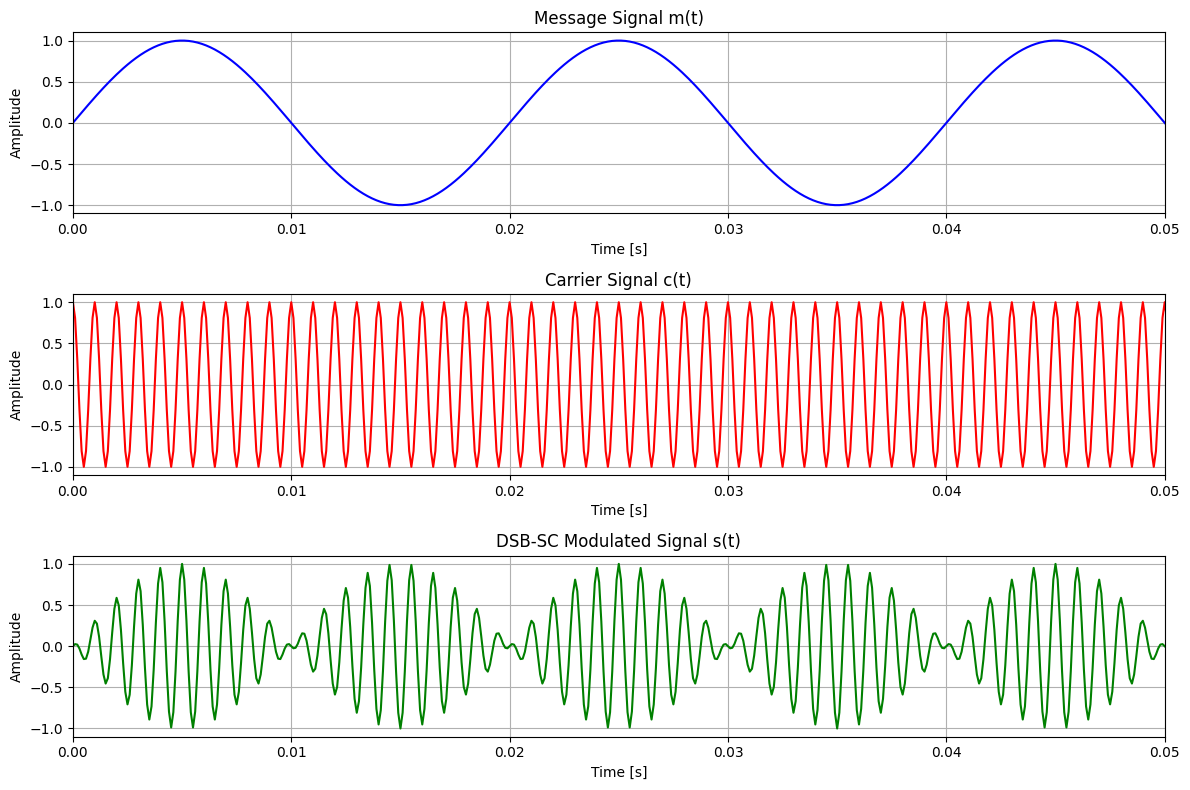

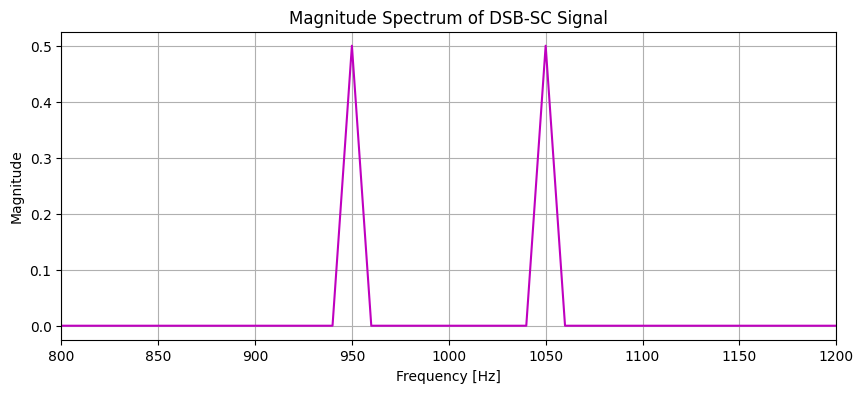

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Sampling Parameters
Fs = 10000                 # Sampling frequency (Hz)
T = 0.1                    # Duration of signal (seconds)
t = np.arange(0, T, 1/Fs)  # Time vector

# Baseband signal (message)
Am = 1                     # Message amplitude
fm = 50                    # Message frequency (Hz)
m_t = Am * np.sin(2 * np.pi * fm * t)

# Carrier signal
fc = 1000                         # Carrier frequency (Hz)
c_t = np.cos(2 * np.pi * fc * t)  # amplitude = 1 for DSB-SC

# DSB-SC Modulated signal
s_dsbsc = m_t * c_t  # No carrier term added

# Time-domain plots
plt.figure(figsize=(12, 8))

plt.subplot(3,1,1)
plt.plot(t, m_t, 'b', linewidth=1.5)
plt.title('Message Signal m(t)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.xlim(0, 0.05)
plt.grid(True)

plt.subplot(3,1,2)
plt.plot(t, c_t, 'r', linewidth=1.5)
plt.title('Carrier Signal c(t)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.xlim(0, 0.05)
plt.grid(True)

plt.subplot(3,1,3)
plt.plot(t, s_dsbsc, 'g', linewidth=1.5)
plt.title('DSB-SC Modulated Signal s(t)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.xlim(0, 0.05)
plt.grid(True)

plt.tight_layout()
plt.show()

# Frequency-domain analysis
N = len(s_dsbsc)
S_f = np.fft.fft(s_dsbsc)/N
f = np.fft.fftfreq(N, 1/Fs)

f_pos = f[:N//2]
S_f_pos = 2 * np.abs(S_f[:N//2])

plt.figure(figsize=(10,4))
plt.plot(f_pos, S_f_pos, 'm', linewidth=1.5)
plt.title("Magnitude Spectrum of DSB-SC Signal")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.grid(True)
plt.xlim(fc - 200, fc + 200)
plt.show()

### Demodulation

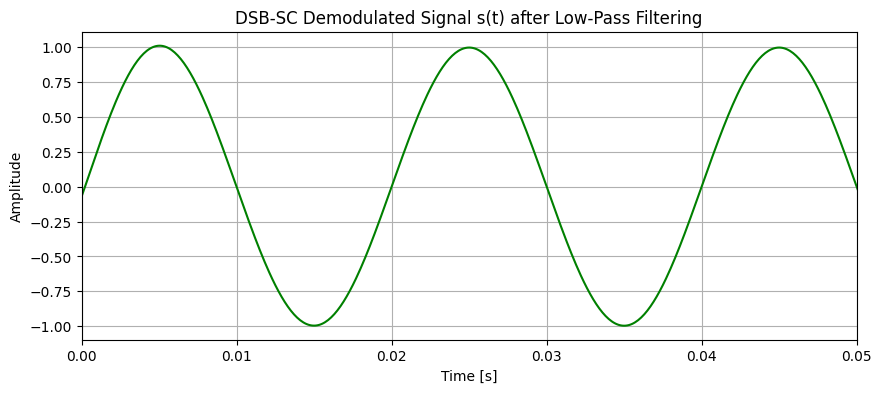

In [31]:
from scipy.signal import butter, filtfilt

demod_1 = s_dsbsc * c_t  

# Butterworth low-pass filter design
order = 4
nyq = 0.5 * Fs
normal_cutoff = (2 * fm) / nyq

b, a = butter(order, normal_cutoff, btype='low', analog=False)
filtered = filtfilt(b, a, demod_1) * 2

plt.figure(figsize=(10, 4))
plt.plot(t, filtered, 'g', linewidth=1.5)
plt.title('DSB-SC Demodulated Signal s(t) after Low-Pass Filtering')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.xlim(0, 0.05)
plt.grid(True)
plt.show()

### DSB-SC Synchronous Demodulation (Receiver)

The following code performs synchronous detection exactly as required: local carrier generation, multiplication, Butterworth LPF, `filtfilt`, and scaling/shift correction.


DSB-SC Synchronous Demodulation Metrics:
LPF cutoff = 350 Hz, Filter order = 4
MSE = 0.00000005
Correlation = 1.0000


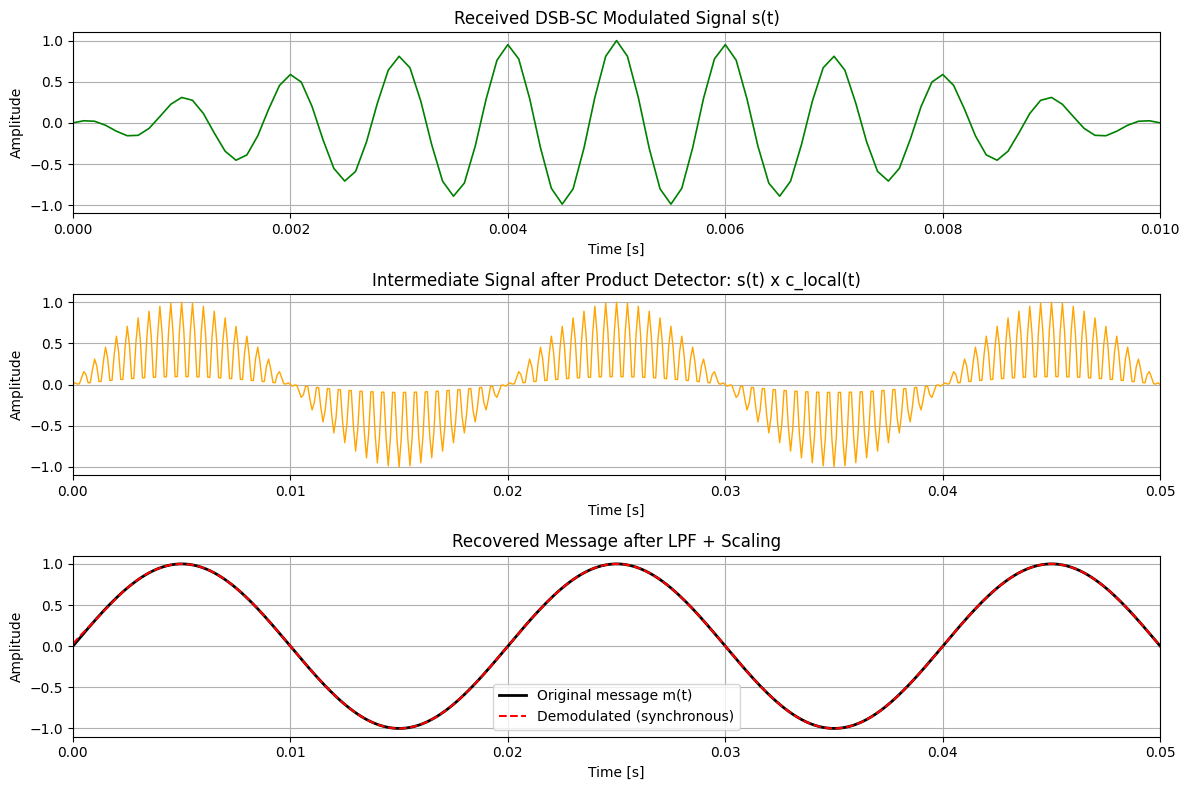

In [3]:
from scipy.signal import butter, filtfilt
import numpy as np
import matplotlib.pyplot as plt

# Local carrier at receiver (phase-synchronized)
local_carrier = np.cos(2 * np.pi * fc * t)

# Multiply received DSB-SC with local carrier
mixed_signal = s_dsbsc * local_carrier

# Define message bandwidth 
BW_message = 300  # Hz
lpf_cutoff = 350  

# Butterworth LPF design
order = 4
nyq = 0.5 * Fs
b, a = butter(order, lpf_cutoff / nyq, btype='low', analog=False)

baseband_recovered = filtfilt(b, a, mixed_signal)

demod_scaled = 2 * baseband_recovered
demod_final = demod_scaled - np.mean(demod_scaled)  

edge = int(0.01 * Fs)
valid = slice(edge, -edge if edge > 0 else None)
mse = np.mean((m_t[valid] - demod_final[valid]) ** 2)
corr = np.corrcoef(m_t[valid], demod_final[valid])[0, 1]

print('DSB-SC Synchronous Demodulation Metrics:')
print(f'LPF cutoff = {lpf_cutoff} Hz, Filter order = {order}')
print(f'MSE = {mse:.8f}')
print(f'Correlation = {corr:.4f}')

# Essential plots only
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t, s_dsbsc, 'g', linewidth=1.2)
plt.title('Received DSB-SC Modulated Signal s(t)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.xlim(0, 0.01)
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t, mixed_signal, color='orange', linewidth=1.0)
plt.title('Intermediate Signal after Product Detector: s(t) x c_local(t)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.xlim(0, 0.05)
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t, m_t, 'k', linewidth=2, label='Original message m(t)')
plt.plot(t, demod_final, 'r--', linewidth=1.5, label='Demodulated (synchronous)')
plt.title('Recovered Message after LPF + Scaling')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.xlim(0, 0.05)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Observations (DSB-SC Demodulation)

1. The mixer output `s(t) * c_local(t)` contains two components: a baseband term and a high-frequency term around `2fc`.
2. The Butterworth LPF suppresses the `2fc` component and preserves the baseband message component.
3. After scaling by 2 and removing small DC offset, the recovered signal closely matches the original message in shape and amplitude.
4. Small mismatch near start/end samples appears due to filter transient behavior.

### Analysis / Discussion

1. Synchronous detection works because the receiver multiplies by a carrier with the same frequency and phase as the transmitter carrier.
2. For DSB-SC, there is no transmitted carrier; therefore coherent (synchronous) detection is required for faithful recovery.
3. LPF cutoff must be above message bandwidth and much lower than carrier-related terms to separate useful baseband from high-frequency products.
4. If carrier phase/frequency mismatch exists, recovered amplitude reduces and distortion increases.

### Conclusion

Synchronous demodulation successfully recovered the DSB-SC message signal. The product detector created baseband and high-frequency components; the LPF extracted baseband, and scaling/shift correction restored amplitude and zero-mean shape. The close overlap between original and recovered waveforms, supported by low MSE and high correlation, confirms correct DSB-SC demodulation.
